<a href="https://colab.research.google.com/github/hamiin47/OB-session/blob/main/Assign_0519.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **5.2 합성곱 신경망 맛보기**

In [1]:
# 라이브러리 호출
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms   # 데이터 전처리를 위해 사용하는 라이브러리
from torch.utils.data import Dataset, DataLoader

파이토치는 기본적으로 GPU 사용을 권장한다

In [2]:
# CPU 혹은 GPU 장치 확인
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


일반적으로 하나의 GPU를 사용할 때는 다음과 같은 코드를 이용한다.

```
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Net()
model.to(device)
```

그러나 사용하는 PC에서 다수의 GPU를 사용한다면 다음 코드와 같이 nn.DataParallel을 이용한다.

```
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Net()
if torch.cuda.device_count() > 1:
   model = nn.DataParallel(net)
model.to(device)
```




In [3]:
# fashion_mnist 데이터셋 내려받기

train_dataset = torchvision.datasets.FashionMNIST("../chap05/data", download=True,
                                                  transform=transforms.Compose([transforms.ToTensor()]))
test_dataset = torchvision.datasets.FashionMNIST("../chap05/data", download=True, train=False,
                                                 transform=transforms.Compose([transforms.ToTensor()]))
                                                 # 앞에서 훈련 데이터셋을 내려받았다면 여기에서는 테스트 데이터셋을 내려받음


100%|██████████| 26.4M/26.4M [00:02<00:00, 11.9MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 201kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.79MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 8.35MB/s]


torchivision.datasets는 torch.utils.data.Dataset의 하위 클래스로 다양한 데이터셋을 포함한다.

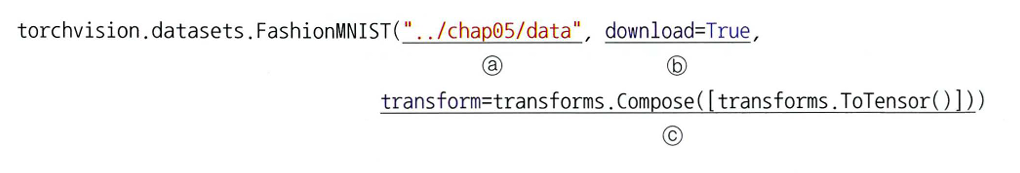

In [4]:
# fashion_mnist 데이터를 데이터로더에 전달
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=100)   # 1
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=100)

torch.utils.data.DataLoader()를 사용하여 원하는 크기의 배치 단위로 데이터를 불러오거나 순서가 무작위로 섞이도록 할 수 있다.

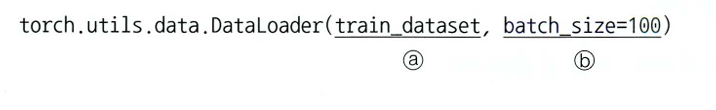

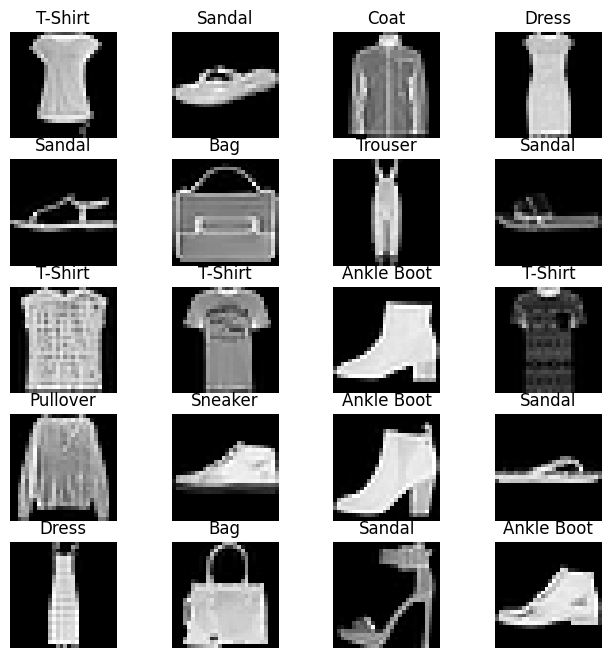

In [5]:
# 분류에 사용될 클래스 정의
labels_map = {0: 'T-Shirt', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat',
              5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle Boot'}   # 열 개의 클래스

fig = plt.figure(figsize=(8,8))   # 출력할 이미지의 가로세로 길이로, 단위는 inch
columns = 4;
rows = 5;
for i in range(1, columns*rows +1):
    img_xy = np.random.randint(len(train_dataset));   # 1
    img = train_dataset[img_xy][0][0,:,:]             # 2
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap='gray')
    plt.title(labels_map[train_dataset[img_xy][1]])
    plt.axis('off')
    plt.imshow(img, cmap='gray')
plt.show()   # 20개의 이미지 데이터를 시각적으로 표현

1)
- np.random은 무작위로 데이터를 생성할 때 사용한다.
- np.random.randint()는 이산형 분포를 갖는 데이터에서 무작위 표본을 추출할 때 사용합니다.

=> random.randint는 0~(train_dataset의 길이) 값을 갖는 분포에서 랜덤한 숫자 한 개를 생성하라는 의미이다.



In [6]:
np.random.randint(10)     # 0~10의 임의의 숫자 출력

4

In [7]:
np.random.randint(1, 10)  # 1~9의 임의의 숫자 출력

5

In [8]:
np.random.rand(8)         # 0~1 사이의 정규표준분포 난수를 행렬로 (1x8) 출력

array([0.70578894, 0.18717278, 0.38539604, 0.92724984, 0.87108987,
       0.97669659, 0.71486142, 0.11987339])

In [9]:
np.random.rand(4, 2)      # 0~1 사이의 정규표준분포 난수를 행렬로 (4x2) 출력

array([[0.70129317, 0.62330682],
       [0.46945567, 0.37256837],
       [0.33453575, 0.29008656],
       [0.15807313, 0.71791109]])

In [10]:
np.random.rand(8)         # 평균이 0이고, 표준편차가 1인 가우시안 정규분포 난수를 행렬로 (1x8) 출력

array([0.21233372, 0.95005789, 0.73093947, 0.26649777, 0.62610012,
       0.72529656, 0.61859079, 0.13592548])

In [11]:
np.random.randn(4, 2)     # 평균이 0이고, 표준편차가 1인 가우시안 정규분포 난수를 행렬로 (4x2) 출력

array([[ 0.11181172, -0.3858709 ],
       [ 0.36258553,  0.90337282],
       [ 0.91499087, -1.46639638],
       [ 0.46250363, -0.2693778 ]])

2)
- train_dataset을 이용한 3차원 배열을 생성한다

In [12]:
examp = np.arange(0, 100, 3)  # 1~99의 숫자에서 3씩 건너뛴 행렬을 생성
examp.resize(6, 4)
examp

array([[ 0,  3,  6,  9],
       [12, 15, 18, 21],
       [24, 27, 30, 33],
       [36, 39, 42, 45],
       [48, 51, 54, 57],
       [60, 63, 66, 69]])

In [13]:
examp[3]                      # 3행에 해당하는 모든 값들을 출력(행과 열은 0부터 시작)

array([36, 39, 42, 45])

In [14]:
examp[3, 3]                   # 3행의 3번째 열에 대한 값을 출력

np.int64(45)

In [15]:
examp[3][3]                      # 3행의 3번째 열에 대한 값을 출력하기 때문에 바로 앞의 결과와 동일

np.int64(45)

 train_dataset[img_xy][0][0,:,:] 의 의미는 train_dataset에서 [img_xy][0][0,:,:]에 해당하는 요소 값을 가져오겠다는 의미이다.

In [16]:
examp = np.arange(0,500,3)
examp.resize(3,5,5)
examp

array([[[  0,   3,   6,   9,  12],
        [ 15,  18,  21,  24,  27],
        [ 30,  33,  36,  39,  42],
        [ 45,  48,  51,  54,  57],
        [ 60,  63,  66,  69,  72]],

       [[ 75,  78,  81,  84,  87],
        [ 90,  93,  96,  99, 102],
        [105, 108, 111, 114, 117],
        [120, 123, 126, 129, 132],
        [135, 138, 141, 144, 147]],

       [[150, 153, 156, 159, 162],
        [165, 168, 171, 174, 177],
        [180, 183, 186, 189, 192],
        [195, 198, 201, 204, 207],
        [210, 213, 216, 219, 222]]])

In [17]:
examp[2][0][3]

np.int64(159)

합성곱 신경망과 합성곱 신경망이 아닌 심층 신경망의 비교를 위해 먼저 심층 신경망을 생성한 후 학습시킨다.

In [18]:
# 심충 신경망 모델 생성
class FashionDNN(nn.Module):
    def __init__(self):   # 1
        super(FashionDNN, self).__init__()
        self.fc1 = nn.Linear(in_features=784, out_features=256)   # 2
        self.drop = nn.Dropout(0.25)   # 3
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)

    def forward(self, input_data):   # 4
        out = input_data.view(-1, 784)   # 5
        out = F.relu(self.fc1(out))   # 6
        out = self.drop(out)
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

1) 클래스 형태의 모델은 항상 torxh.nn.Modyle을 상속받는다.

2) nn은 딥러닝 모델 구성에 필요한 모듈이 모여 있는 패키지이며, Linear는 단순 선형 회귀 모델을 만들 떄 사용된다.

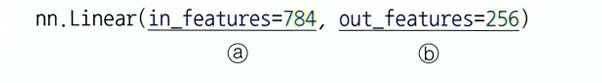

  - in_features : 입력의 크기
  - out_features : 출력의 크기

3) torxh.nn.Dropout(p)는 p만큼의 비율로 텐서의 값이 0이 되고, 0이 되지 않는 값들은 기존 값에 (1/(1-p))만큼 곱해져 커진다.

4) forward() 함수는 모델이 학습 데이터를 입력받아 순전파 학습을 진행시키며, 반드시 forward라는 이름의 함수여야한다.

5) 파이토치에서 사용하는 뷰는 넘파이의 reshape과 같은 역할로 텐서의 크기를 변경해 주는 역할을 한다.

6) 활성화 함수를 지정할 때는 다음 두 가지 방법이 가능하다
  - F.relu() ; forward()함수에서 정의
  - nn.ReLU() : _ _init_ _() 함수에서 정의
  => 활성화 함수 사용에 한정하여 이 둘의 차이는 사용하는 위치이다.

In [19]:
# nn을 사용하는 예시 코드

import torch
import torch.nn as nn

inputs = torch.randn(64, 3, 244, 244)
conv = nn.Conv2d(in_channels=3, out_channels=64,
                 kernel_size=3, padding=1) # 채널 3개 입력 -> 64개 출력을 위해 3x3크기의 커널 사용
outputs = conv(inputs)
layer = nn.Conv2d(1,1,3)

In [20]:
# nn.functional을 사용하는 예시 코드

import torch.nn.functional as F

inputs = torch.randn(64, 3, 244, 244)
weight = torch.randn(64, 3, 3, 3)
bias = torch.randn(64)
outputs = F.conv2d(inputs, weight, bias, padding=1)

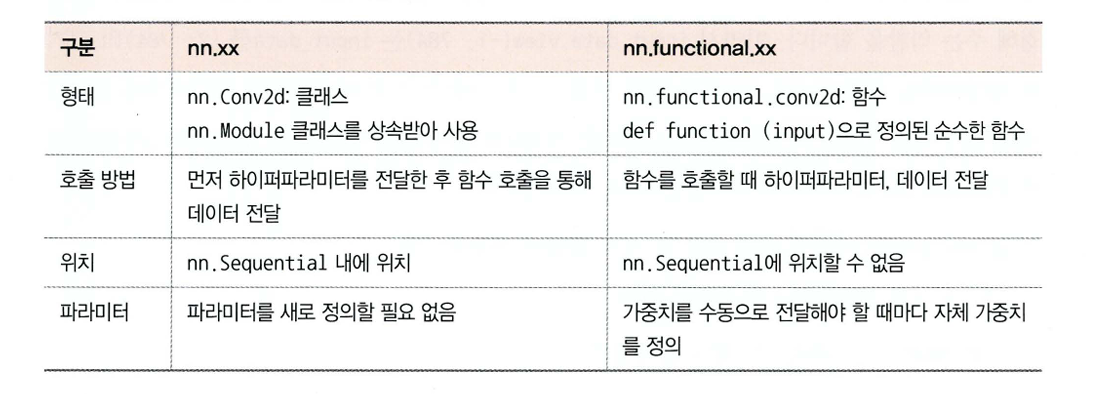

In [21]:
# 심층 신경망에서 필요한 파라미터 정의
learning_rate = 0.001;
model = FashionDNN();
model.to(device)

criterion = nn.CrossEntropyLoss(); # 분류 문제에서 사용하는 손실 함수
optimizer = torch.optim.Adam(model.parameters(), lr =learning_rate); #1
print(model)

FashionDNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


옵티마이저를 위한 경사 하강법은 Adam을 사용하며, 학습률을 의미하는 lr은 0.001을 사용한다

In [22]:
# 심층 신경망을 이용한 모델 학습
num_epochs = 5
count = 0
loss_list = []   # 1
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:   # 2
        images, labels = images.to(device), labels.to(device)   # 3

        train = Variable(images.view(100, 1, 28, 28))   # 4
        labels = Variable(labels)

        outputs = model(train)   # 학습 데이터를 모델에 적용
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1

        if not (count % 50):   # count를 50으로 나누었을 때 나머지가 0이 아니라면 실행
            total = 0
            correct = 0
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)

                test = Variable(images.view(100, 1, 28, 28))

                outputs = model(test)
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()

                total += len(labels)

            accuracy = correct * 100 / total   # 5
            loss_list.append(loss.data)        # 1'
            iteration_list.append(count)
            accuracy_list.append(accuracy)

        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data,
                                                                  accuracy))

Iteration: 500, Loss: 0.5885261297225952, Accuracy: 83.30000305175781%
Iteration: 1000, Loss: 0.4578894376754761, Accuracy: 84.5%
Iteration: 1500, Loss: 0.3312115967273712, Accuracy: 84.5%
Iteration: 2000, Loss: 0.4122583270072937, Accuracy: 85.47000122070312%
Iteration: 2500, Loss: 0.23056629300117493, Accuracy: 86.66999816894531%
Iteration: 3000, Loss: 0.259822815656662, Accuracy: 86.61000061035156%


1) 배열이나 행렬과 같은 리스트를 사용하는 방법
  - 비어 있는 배열이나 행렬을 만든다
  - append 메서드를 이용하여 데이터를 하나씩 추가한다.

2) for 구문을 사용하여 레코드를 하나씩 가져온다.

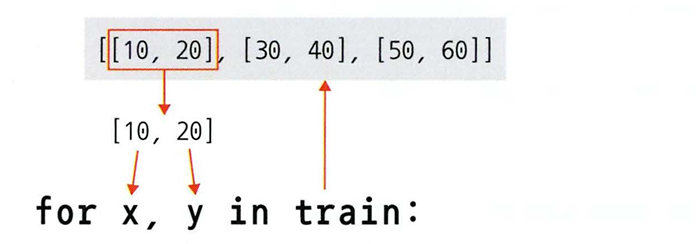

3) 모델이 데이터를 처리하기 위해서는 모델과 데이터가 동일한 장치에 있어야 한다.

4) Autograd는 자동 미분을 수행하는 파이토치의 핵심 패키지로, 자동 미분에 대한 값을 저장하기 위해 tape을 사용한다.
  - 순전파 단계 : 수행하는 모든 연산을 저장한다.
  - 역전파 단계 : 저장된 값들을 꺼내서 사용합니다.
  => Autograd는 Variable을 사용하여 역전파를 위한 미분 값을 자동으로 계산해주며 자동 미분을 계산하기 위해서는 Variable을 이용해야 동작한다.

5) 정확도는 전체 예측에 대한 정확한 예측의 비율로 표현할 수 있다.



```
classification accuracy = correct predictions / total predictions

#백분율
classification accuracy = correct predictions / total predictions * 100

#오분류율/오류율
error rate = (1-(correct predictions / total predictions)) * 100
```





In [23]:
# 합성곱 네트워크 생성
class FashionCNN(nn.Module) :
    def __init__(self) :
        super(FashionCNN, self).__init__()
        self.layer1 = nn.Sequential(  # 1
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1), # 2
            nn.BatchNorm2d(32), # 3
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # 4
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600) # 5
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10) # 마지막 계층의 out_features는 클래스 개수를 의미

    def forward(self, x) :
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1) # 6
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

1) nn.Sequential은 계층을 차례로 쌓을 수 있도록 Wx + b 와 같은 수식과 활성화 함수를 연결해주는 역할을 한다.

2) 합성곱층은 합성곱 연산을 통해서 이미지의 특징을 추출한다.
  - 합성곱이란 커널이라는 n x m 크기의 행렬이 높이 너비 크기의 이미지를 처음부터 끝까지 훑으면서 각 원소 값끼리 곱한 후 모두 더한 값을 출력한다.
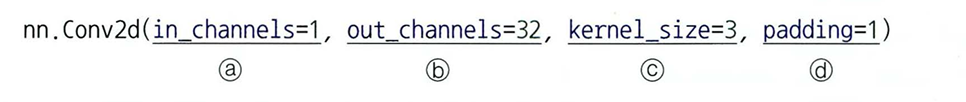

    - in_channels : 입력 채널의 수 / 흑백 이미지는 1, RGB 값을 가진 이미지는 3을 가진 경우가 많다
    - out_channels ; 출력 채널의 수를 의미한다
    - kernel_size ; 커널 크기를 의미하며 필터라고도 한다. / 커널은 이미지 특징을 찾아내기 위한 공용 파라미터이며, CNN에서 학습 대상은 필터 파라미터가 된다. / 커널은 입력 데이터를 스트라이드 간격으로 순화하면서 합성곱을 계산한다.
    - padding ; 패딩 크기르 의미하며 출력 크기를 조정하기 위해 입력 데이터 주위에 0을 채운다./ 패딩 값이 클수록 출력 크기도 커진다.

3) BatchNorm2d : 학습 과정에서 각 배치 단위별로 데이터가 다양한 분포를 가지더라도 평균과 분산을 이용하여 정규화하는 것을 의미한다.

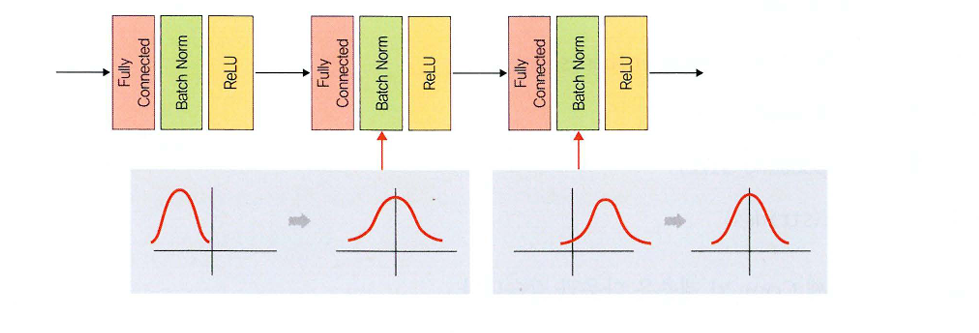

4) MaxPool2d : 이미지 크기를 축소시키는 용도로 사용된다.
  - 풀링 계층은 합성곱층의 출력 데이터를 입력으로 받아 출력 데이터의 크기를 줄이거나 특징 데이터를 강조하는 용도로 사용됨
  - 풀링 계층을 처리하는 방법으로는 최대 풀링과 평균 풀링, 최소 풀링이 있다.

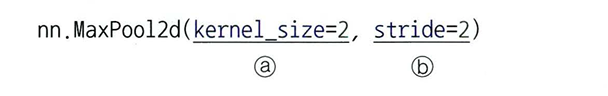

    - kernel_size : m x n 행렬로 구성된 가중치
    - stride : 입력 데이터에 커널을 적용할 때 이동할 간격을 의미하는데, 스트라이드 값이 커지면 출력 크기는 작아진다

5) 클래스를 분류하기 위해서는 이미지 형태의 데이터를 배열 형태로 변환하여 작업해야한다.
  - 패딩과 스트라이드의 값에 따라 출력 크기가 달라짐
  - 줄어든 출력 크기는 최종적으로 분류를 담당하는 완전연결층으로 전달된다

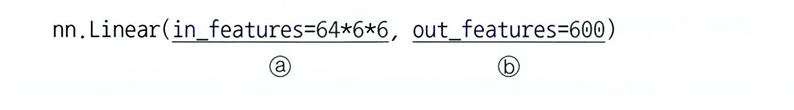

    - in_features : 입력 데이터의 크기

**conv2d 계층에서의 출려 크기 구하는 공식**

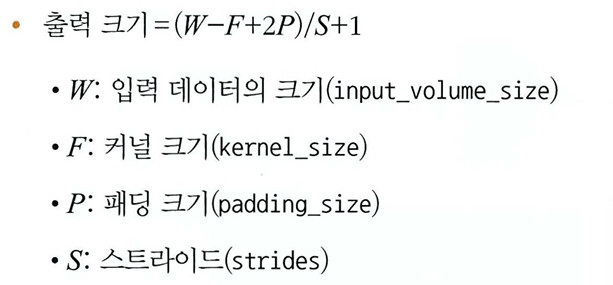


MaxPool2d 계층에서의 출력 크기 구하는 공식

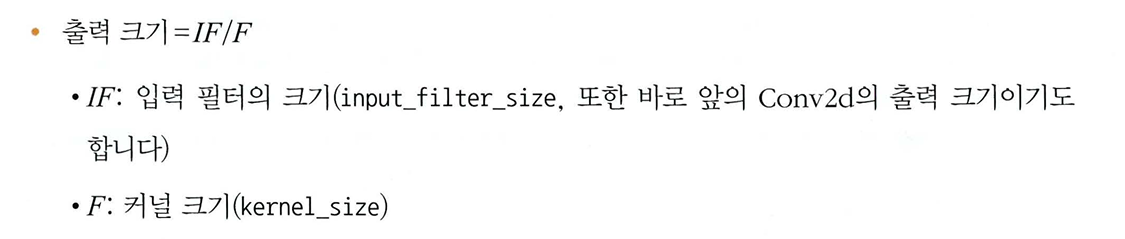

6) 합성곱층에서 완전연결층으로 변경되기 때문에 데이터의 형태를 1차원으로 바꾸어 준다.
  - out.size(0)은 100을 의미한다

In [24]:
# 합성곱 네트워크를 위한 파라미터 정의
learning_rate = 0.001;
model = FashionCNN();
model.to(device)

criterion = nn.CrossEntropyLoss();
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate);
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [25]:
# 모델 학습 및 성능 평가
num_epochs = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)

        outputs = model(train)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1

        if not (count % 50):
            total = 0
            correct = 0
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
                test = Variable(images.view(100, 1, 28, 28))
                outputs = model(test)
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
                total += len(labels)

            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)

        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data,
                                                                  accuracy))

/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Iteration: 500, Loss: 0.4679994583129883, Accuracy: 88.01000213623047%
Iteration: 1000, Loss: 0.30092236399650574, Accuracy: 88.36000061035156%
Iteration: 1500, Loss: 0.25466427206993103, Accuracy: 89.72000122070312%
Iteration: 2000, Loss: 0.19279232621192932, Accuracy: 89.13999938964844%
Iteration: 2500, Loss: 0.145927295088768, Accuracy: 90.16999816894531%
Iteration: 3000, Loss: 0.20800109207630157, Accuracy: 89.91999816894531%


- 심층 신경망과 비교하여 정확도가 약간 높다
- 이미지 데이터가 많아지면 단순 심층 신경망으로는 정확한 특성 추출 및 분류가 불가능하므로 합성곱 신경망을 생성할 수 있도록 학습해야한다